In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from tqdm import tqdm

import gym
import numpy as np
from collections import deque

# Create the environment only once
env = gym.make("CliffWalking-v0")#, render_mode="human")  

# Constants
DISCOUNT_FACTOR = 0.99
NUM_EPISODES = 100
MAX_STEPS = 150
SOLVED_SCORE = 195  # Adjust as needed
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Neural Network for Policy
class PolicyNetwork(nn.Module):
    def __init__(self, state_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(state_space, 128)
        self.output_layer = nn.Linear(128, action_space)

    def forward(self, x):
        # Ensure correct reshaping
        #######
        #######
        x = x.view(x.size(0), -1)  # Reshape to (batch_size, state_space)
        x = F.relu(self.input_layer(x))
        action_scores = self.output_layer(x)
        return F.softmax(action_scores, dim=1)

# Neural Network for State Value
class StateValueNetwork(nn.Module):
    def __init__(self, state_space):
        super(StateValueNetwork, self).__init__()
        self.input_layer = nn.Linear(state_space, 128)
        self.output_layer = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.input_layer(x))
        return self.output_layer(x)

# ## Function to select actions
# def select_action(policy_network, state):
#     if not isinstance(state, int):
#         raise ValueError("Invalid state received")  # Error handling
#     state = torch.nn.functional.one_hot(torch.tensor(state), 48).float().unsqueeze(0).to(DEVICE) # Wrap in a NumPy array if not already
#     print(f"State before reshape: {state}")
#     # Reshape to (1, state_space)
#     #state = state.reshape(1, 48)
#     #state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
#     action_probs = policy_network(state)
#     m = Categorical(action_probs)
#     action = m.sample()
#     return action.item(), m.log_prob(action)
def select_action(policy_network, state):
    state_tensor = torch.nn.functional.one_hot(torch.tensor(state), num_classes=48).float().to(DEVICE).unsqueeze(0)
    action_probs = policy_network(state_tensor)
    m = Categorical(action_probs)
    action = m.sample()
    return action.item(), m.log_prob(action)

In [12]:
# Correctly initialize state from environment
state_tuple = env.reset()  # Get the full initial state tuple
state = state_tuple[0]  # Access the first element (state)

# Initialize Cliff Walking environment
env = gym.make("CliffWalking-v0")#, render_mode="rgb_array")
state_space = env.observation_space.n  # Verify this value is 48
action_space = env.action_space.n

# Initialize networks
policy_network = PolicyNetwork(state_space, action_space).to(DEVICE)
state_value_network = StateValueNetwork(state_space).to(DEVICE)

# Initialize optimizers
policy_optimizer = optim.Adam(policy_network.parameters(), lr=0.01)
state_value_optimizer = optim.Adam(state_value_network.parameters(), lr=0.01)



In [13]:
env = gym.make("CliffWalking-v0")
state_space = env.observation_space.n
print(state_space)  # Added to print the value


48


In [14]:
# Track scores
scores = []
recent_scores = deque(maxlen=100)

# Training loop
for episode in tqdm(range(NUM_EPISODES)):
    ###maybe this should be just state rather than state_tuple
    state = env.reset()[0]  # Reset environment returns a tuple
    score=0
    I = 1  # Initialize discount factor
    
    for step in range(MAX_STEPS):
        action, log_prob = select_action(policy_network, state)
        next_state, reward, done, _ = env.step(action)[:4]
        score += reward

        #print(f"episode: {episode}, Step: {step}, State: {state}, Action: {action}, Reward: {reward}, New State: {next_state}, Done: {done}, Score: {score}")


        # Convert state, next_state, and reward to PyTorch tensors
        state_tensor = torch.nn.functional.one_hot(torch.tensor(state), 48).float().unsqueeze(0).to(DEVICE) 
        next_state_tensor = torch.nn.functional.one_hot(torch.tensor(next_state), 48).float().unsqueeze(0).to(DEVICE)

        reward_tensor = torch.tensor(reward).float()

        # Calculate state value and next state value
        state_value = state_value_network(state_tensor)
        next_state_value = state_value_network(next_state_tensor)
        
        #NEW - added because cliffwalking env does not return done as True when agent falls off cliff
        if reward == -100:
            done = True
        
        #NEW - check if agent has reached the end of the grid
        if next_state == 47:
            done = True
        
        #if terminal state, next state val is 0
        if done:
            next_state_val = torch.tensor([0]).float().unsqueeze(0).to(DEVICE)

        # Calculate advantage
        advantage = reward_tensor + DISCOUNT_FACTOR * next_state_value - state_value

        # Calculate policy loss and value loss
        policy_loss = -log_prob * advantage.detach()
        value_loss = F.smooth_l1_loss(state_value, reward_tensor + DISCOUNT_FACTOR * next_state_value)

        # Backpropagate
        policy_optimizer.zero_grad()
        state_value_optimizer.zero_grad()
        policy_loss.backward()
        value_loss.backward()
        policy_optimizer.step()
        state_value_optimizer.step()

        if done:
            break

        # Move to the next state
        state = next_state
        I *= DISCOUNT_FACTOR  # Update discount factor

    # Append episode score
    scores.append(score)
    recent_scores.append(score)

    # Early stopping if solved score goal is met
    if np.mean(recent_scores) >= SOLVED_SCORE:
        print(f"Environment solved in episode {episode}")
        break


100%|██████████| 100/100 [00:37<00:00,  2.67it/s]


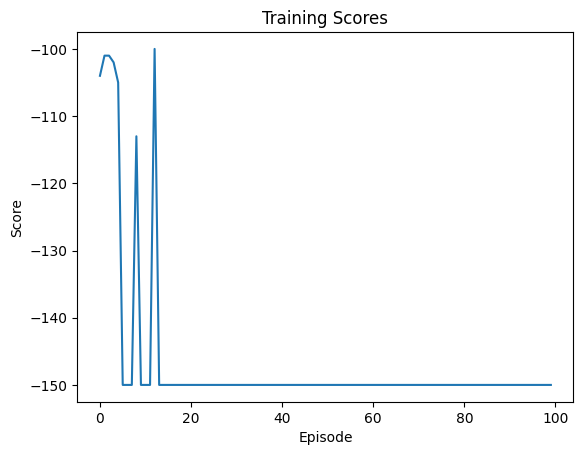

In [15]:
# Plot scores
import matplotlib.pyplot as plt
plt.plot(scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title("Training Scores")
plt.show()

# # Play Cliff Walking with trained model
# state = env.reset()
# done = False
# score = 0
# while not done:
#     env.render()
#     action, _ = select_action(policy_network, state)
#     next_state, reward, done, _ = env.step(action)
#     score += reward
#     state = next_state
# env.close()
# print("Total score:", score)
